# AI Test for McCarthyFinch Senior Data Scientist #

In [284]:
# Imports and load data
import pandas as pd
import numpy as np
from random import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

data = pd.read_csv("../data/t-data.csv")

## Tier 1 ##
The first step in solving a data related problem is to look at the data. Quickly looking at a sample of the data can often quickly tell us what features are important and which are not. Looking at the snippet of the data below, we can quickly see a number of columns that are likely to not be useful in the analysis. They are as listed below

- Priority
- Author
- createdDate
- lastEditedDate

These columns are not likely to have much categorising power. If we look at priority, we can immediately see that there are varying levels of priority for the HR category. Also from a logical point of view, we know that a single category of text may have differing levels of priority, thus making it a unreliable predictor. Obviously the Author is not going to be a good indicator for our classifier since we would want to classify documents that may come in the future that has a previously unseen author.

In [268]:
data.head(10)

,pagesCount,wordCount,fileSize,priority,author,title,createdDate,lastEditedDate,category
0,61,9211,55266,critical,Miss Selena Morse,jobs-relationship,2014-07-15T21:46:52.000Z,2014-08-13T09:46:52.000Z,hr
1,47,5781,40467,medium,Ms. Ida Ware,WELCOME,1997-10-25T13:58:23.000Z,1997-11-01T16:58:23.000Z,hr
2,775,312325,1561625,low,Mrs. Irene Fritz,Fiction Book,1988-05-22T16:01:43.000Z,1988-05-28T05:01:43.000Z,other
3,1469,602290,3613740,medium,Mrs. Luann Bowen,books_right_lima_jane-wyman,1983-09-19T23:06:22.000Z,1983-10-01T22:06:22.000Z,other
4,21,2457,14742,critical,Ms Dawn Phelps,footer-trace-layne-staley,2016-02-23T09:14:27.000Z,2016-03-19T13:14:27.000Z,hr
5,133,66367,265468,critical,Miss Candace Ortiz,micronesia_sukhumi,1993-05-18T11:00:44.000Z,1993-06-06T22:00:44.000Z,sales
6,134,66196,330980,low,Ms. Christa Keller,debate_eritrea_xl_2019_36616,1994-04-14T17:30:02.000Z,1994-05-02T16:30:02.000Z,sales
7,1244,634440,4441080,critical,Mister Christopher Retana,Othello,1999-11-02T21:32:42.000Z,1999-11-04T13:32:42.000Z,other
8,36,5868,29340,low,Mrs. Vanessa Cantu,Agreement to Terminate the Fixed-Term Employm...,2017-12-08T19:00:47.000Z,2017-12-20T12:00:47.000Z,hr
9,1,433,2598,critical,Mr Tom Waters,peru_george-brett_buenos-aires_army,2009-01-07T03:35:20.000Z,2009-02-01T13:35:20.000Z,other


The dates are also not a good feature to used in determining the category of a document. Just thinking about features, we know that any document can be created and modified at anytime, and is therefore unlikely to be a good indicator of category. Looking at the data we can see that this is true. The plot below shows the frequency of the created dates (grouped by year) for the documents in each category, and we can see no indication that the dates have any indicative power for which category a document is in.

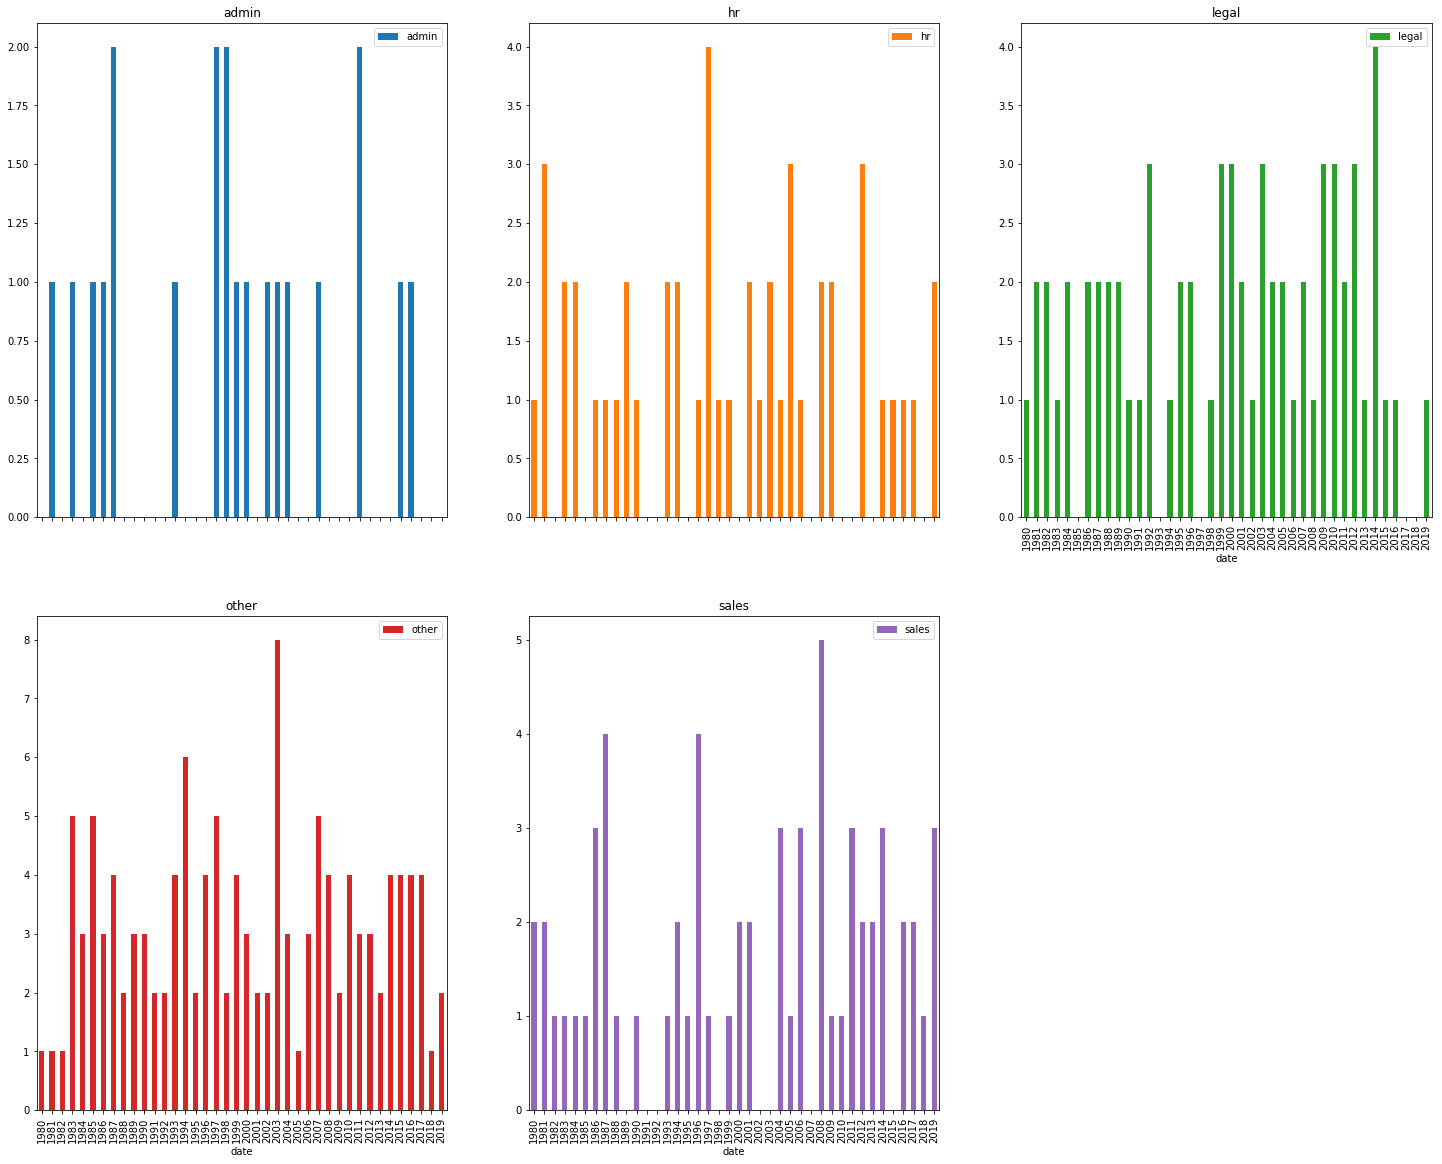

In [292]:
data['date'] = data['createdDate'].str[0:4]
date_data = data.groupby('date').category.value_counts().sort_index()
ax = date_data.unstack().plot(kind='bar', subplots=True, layout=(2,3))
plt.rcParams['figure.figsize'] = [25, 10]
plt.show()

A cursory look at the title column also shows us that this feature is not suitable for use in the classification model. It's quite clear that there is a lot of noise here, with similar words appearing across different categories. For example, if we look at the work "agreement" we can see it appearing with the 'hr', 'legal' and 'other' categories. This is not to say that there is no information in the title, but as we have quite a small dataset, it is unilikey to have enough examples of of the titles to give the classifier adequate information to train on.

Now we are left with "pagesCount", "wordCount" and "fileSize" columns. I have plotted them all in relation to each other below. Even in this form, we can see that there is a distinct clusters for each category. However, the current plots show that the data is likely skewed, and we would want to perform a transformation to observe the data more clearly.

In [270]:
def plot_columns(x, y, groups):
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group[x], group[y], marker='.', linestyle='', label=name)
    plt.xlabel(x)
    plt.ylabel(y) 
    ax.legend()

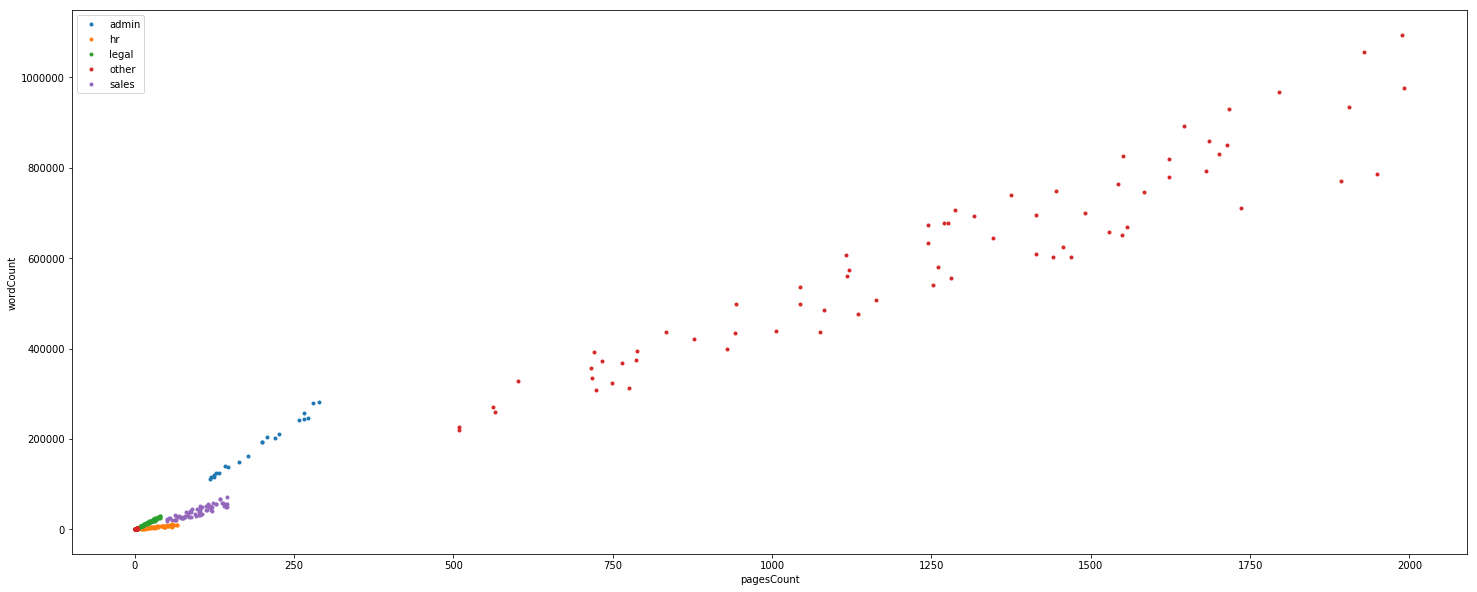

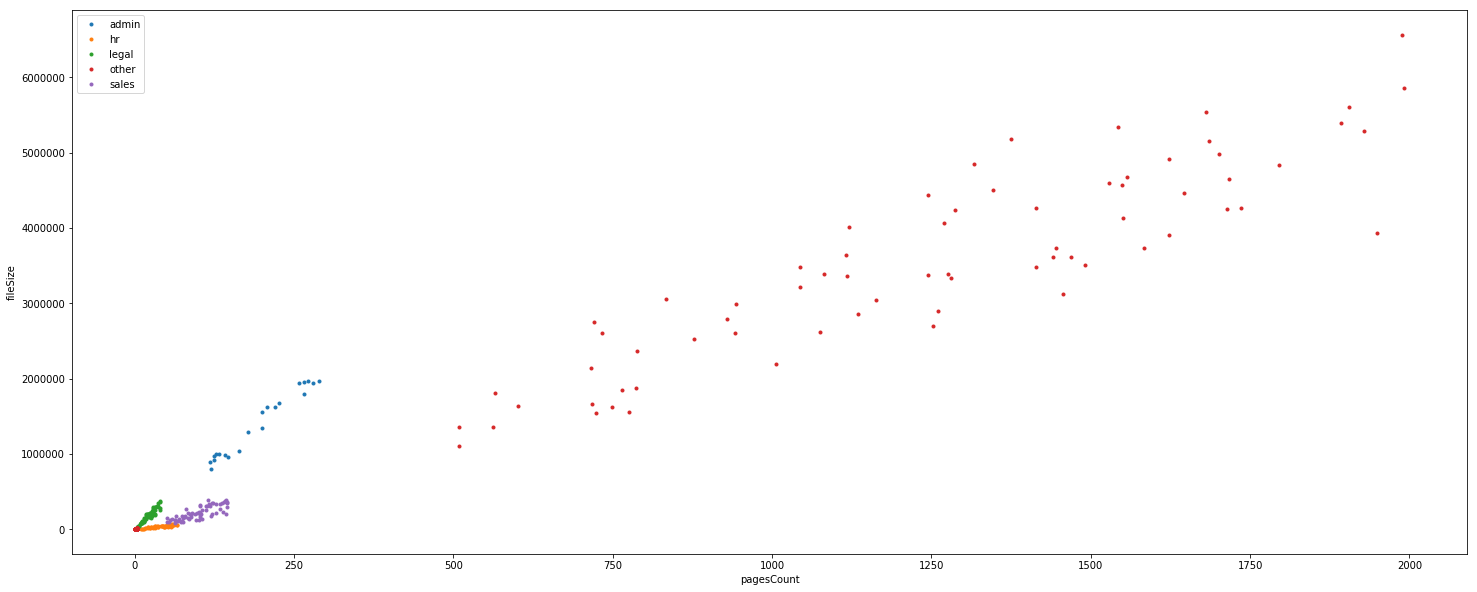

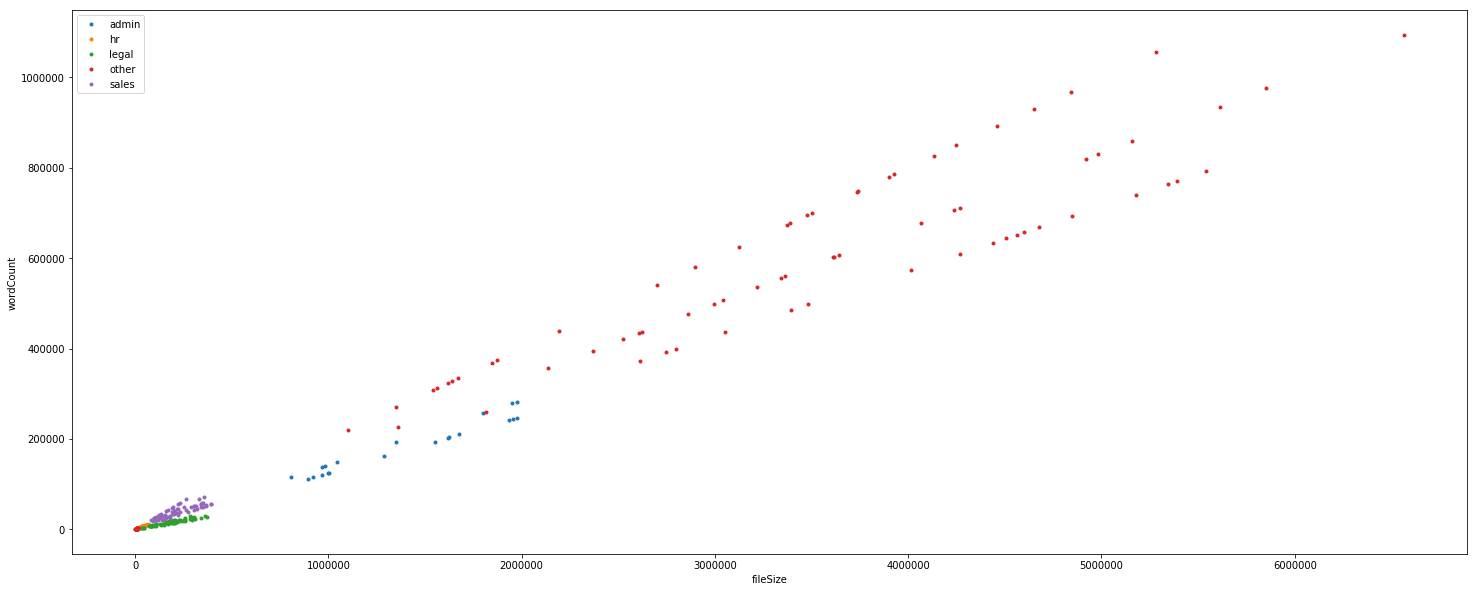

In [293]:
groups = data.groupby('category')
plot_columns('pagesCount', 'wordCount', groups)
plot_columns('pagesCount', 'fileSize', groups)
plot_columns('fileSize', 'wordCount', groups)

From the skew distribution plots below, we can easily see that the data is heavly skewed towards the left. The data is logged to make it more evenly distributed. This can be seen in the log-transformed plots below, where not perfect, the features are no longer strongly skewed.

In [272]:
def distribution(data, transformed = False):
    
    fig = plt.figure(figsize = (11,5));

    for i, feature in enumerate(data.columns[0:3]):
        ax = fig.add_subplot(1, 3, i+1)
        ax.hist(data[feature], bins = 25)
        ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
        ax.set_ylim((0, 230))

    # Plot aesthetics
    if transformed:
        fig.suptitle("Log-transformed Distributions of Features", \
            fontsize = 16, y = 1.03)
    else:
        fig.suptitle("Skewed Distributions of Features", \
            fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()


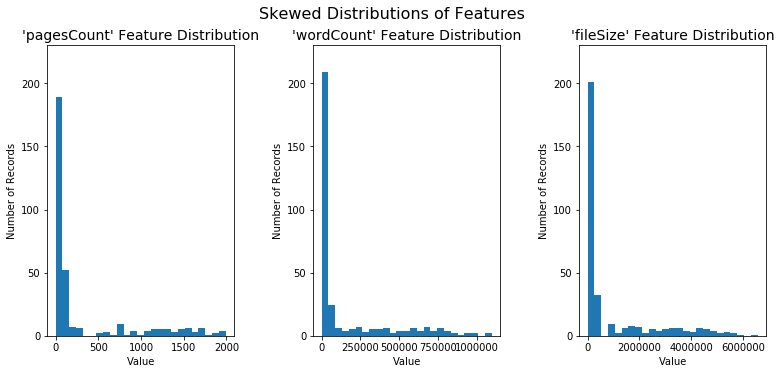

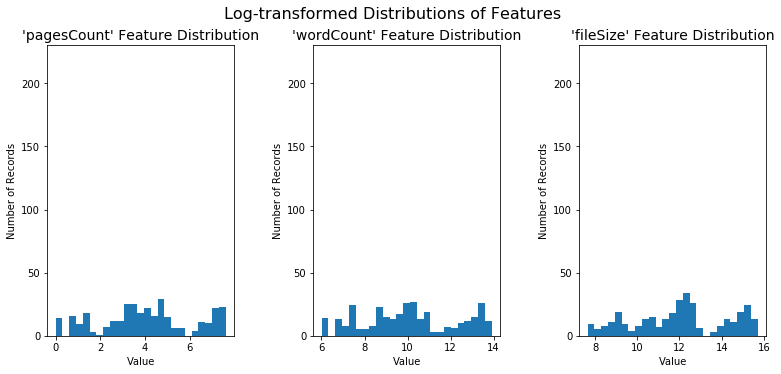

In [294]:
distribution(data[['pagesCount', 'wordCount', 'fileSize']])
transformed_data = np.log(data[['pagesCount', 'wordCount', 'fileSize']])
distribution(transformed_data, transformed=True)

Now we plot the scatter plots again with the transformed data, and we can see clusters that are even more well separated than before.

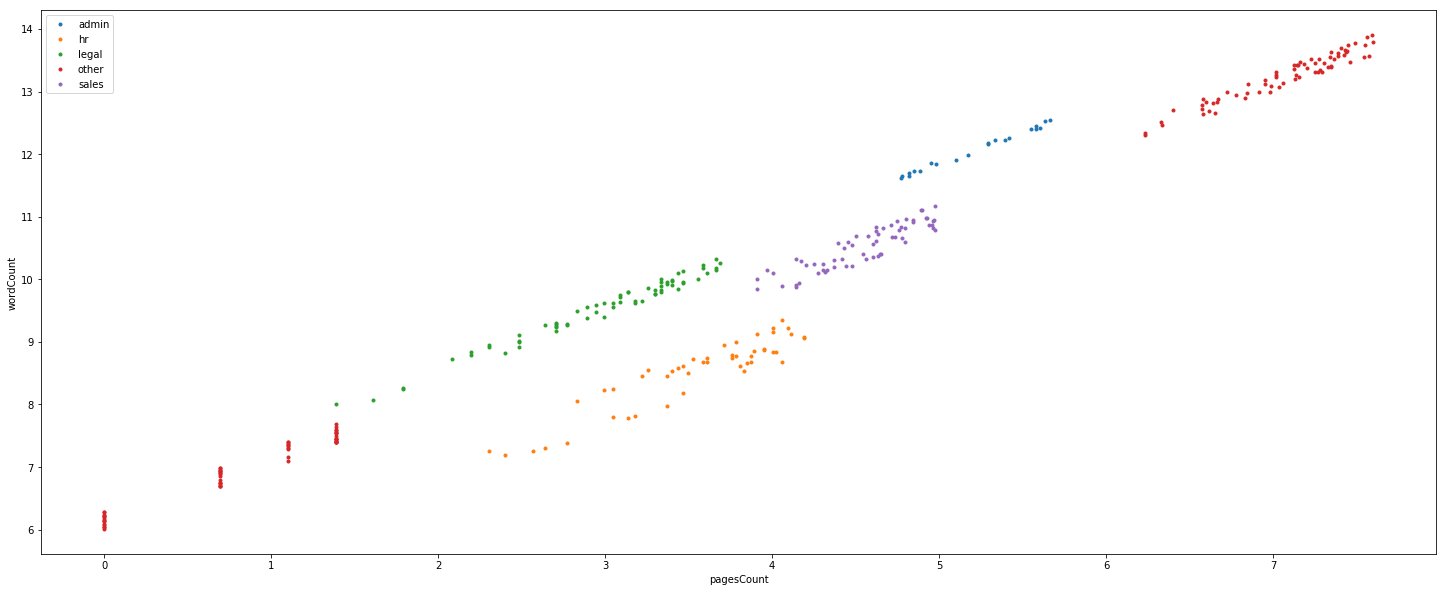

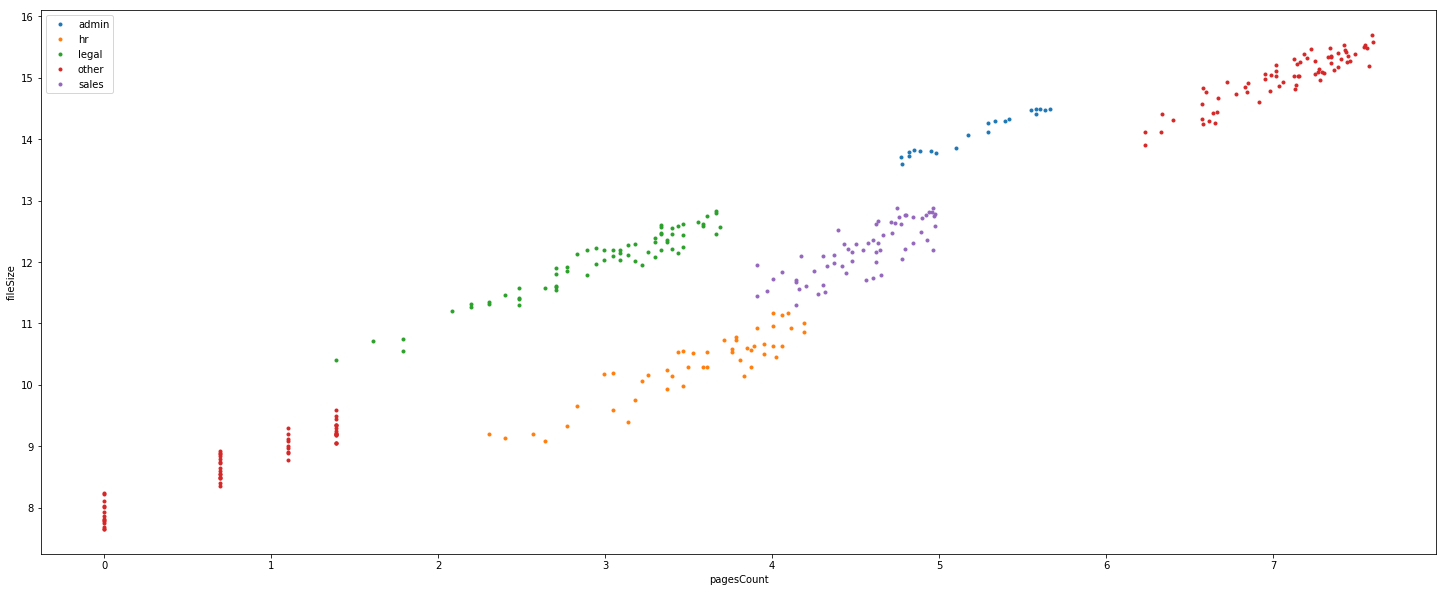

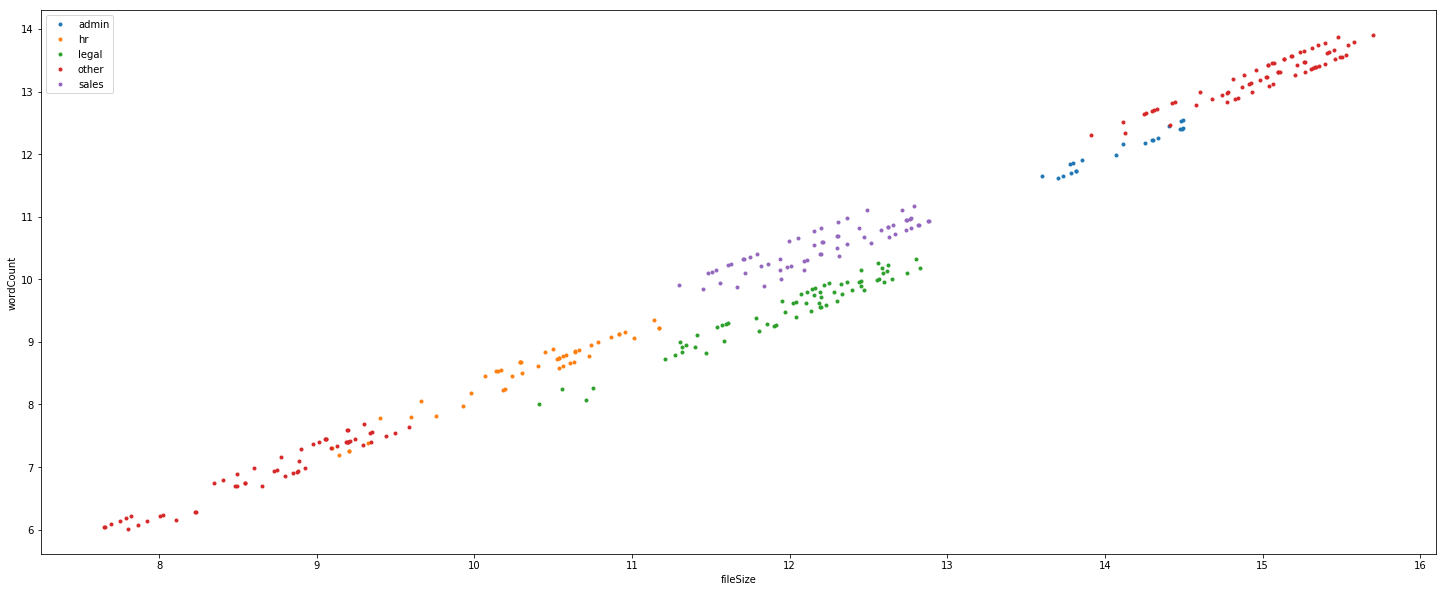

In [295]:
transformed_data['category'] = data['category']
groups = transformed_data.groupby('category')
plot_columns('pagesCount', 'wordCount', groups)
plot_columns('pagesCount', 'fileSize', groups)
plot_columns('fileSize', 'wordCount', groups)

Having looked at the data and visualised the features, I would conclude that there is sufficient data in the "pagesCount", "wordCount" and "fileSize" features for us to build an adaquate classifier for the documents.

## Tier 2 ##
Looking at the plots of the 'pagesCount', 'wordCount', and 'fileSize' we can see that these three features alone separate the different classes of documents quite well. To increase the accuracy, I would collect more data on the content of the documents. We know that models such as naive Bayes classifiers and bag of word models traditionally perform quite well in text classification problems, so it would be benificial to collect data on the main text of each document.

Storing the pure text data as part of the data set is obviously not an ideal situation. This is because each document is likely to have varying lengths of text in different formats, and this could prove difficult to manage depending on the type of data store being used. I think that a good way to store the data is in the form of term frequency associated to each document. The text would undergo preprocessing where all the stop words can be removed, and the subsequent words can be summerised into their frequency of appearance. From here it is easily to store the top N words of interest. This can then easily be added as a separate field to a JSON format, or as a separate column in a table structure.

## Tier 3 ##
## Issues of Overfitting and Underfitting ##
### Overfitting ### 
Overfitting is one of the main challenges faced when dealing with machine learning. To solve overfitting it is important to first catch it. The simplest way to see if a model is overfit is to look at the training accuracy and the testing accuracy. If the training accuracy is high and the testing accuracy is low, the model is likely overfit. To prevent overfitting, it is important to make sure the training data is representative of the entire data population. This makes sure that all characteristics of the data are seen and learned by the model. In this case it is important to sample the categories in the data evenly so that the model has a chance to learn about each category. If overfitting occurs, we can often solve it by obtaining more data, or reducing the training time on the model.

### Underfitting ### 
Underfitting is when the model has not learned the behaviours in the data so the model function well. This can be caused by a variety of reasons. One common reason for underfitting is a oversimplic model. For example, for complicated behaviours, we may need 50 thousand nodes in a neural network to capture the features in the data. In this case, using a network with 20 thousand neurons would likely lead to underfitting. To solve this, we could improve the model complexity to capture more features. Another cause of underfitting could be not training the model for long enough. In such cases, the model will not have converged, and thus the performance would be poor. In this case, we should train the model more, until convergence is reached.

## Tier 4 ##

- Standardization.
- Scaling
- Normalisation
- Dimentionality Reduction

## Tier 5 ##
Data Transform Ranking

**1. Normalisation**

As discussed previously, the columns that we are interested in are slewed. It is very important for most machine learning algorithms to have a balanced dataset. By removing the skew the model is less likely to learn a skewed behaviour. In this case, I think that normalisation by logging the data is the most important transform.

**2. Standardisation**

**3. Scaling**

Standardisation and scaling are important because it allows different features to be compared effectively against each other. Standardisation will transform the features to that they will have a similar mean and scaling will transform the data so that they will have a similar upper and lower range. In this case, I think standardisation is more important. If we look at the data once it has been log transformed, we can see that the three features we are looking athave very similar standard deviations, as well as all having a range of 8. We can also see that the means of the features are different. In this case, scaling will have limited effects on the data since the scales are already similar, so standardisation is more important.

It is also interesting to note that most of the time scaling and standardisation are processes that are performed together. For the purposes of this excise I have discussed them separately, but in reality performing one often entails performing the other.

**4. Dimentionality Reduction**

In this case, since we only have three prominant features, it is unlikely dimentionality reduction is necessary or beneficial.

In [275]:
transformed_data.describe()

,pagesCount,wordCount,fileSize
count,324.000000,324.000000,324.000000
mean,4.020088,10.093932,12.007307
std,2.102657,2.193740,2.188676
min,0.000000,6.008813,7.652071
25%,2.772589,8.612594,10.483110
50%,3.960768,9.966176,12.120377
75%,5.205439,12.035412,13.952001
max,7.596392,13.905306,15.697065


## Tier 6 ##

Here we log the data and center the mean of the features to 0

In [285]:
transformed_data = np.log(data[['pagesCount', 'wordCount', 'fileSize']])
standardised_data = transformed_data[['pagesCount', 'wordCount', 'fileSize']].copy()
standardised_data[:] = pd.DataFrame(preprocessing.StandardScaler().fit_transform(transformed_data[['pagesCount', 'wordCount', 'fileSize']]))

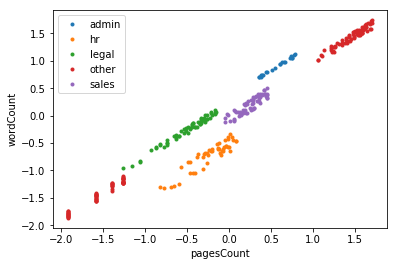

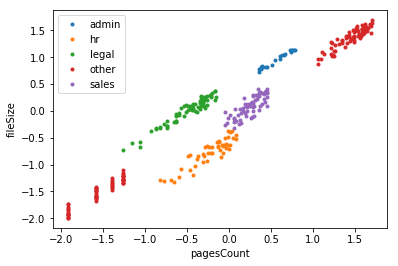

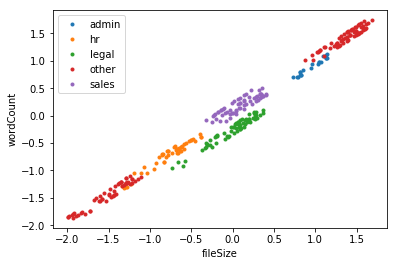

In [287]:
standardised_data['category'] = data['category']
groups = standardised_data.groupby('category')
plot_columns('pagesCount', 'wordCount', groups)
plot_columns('pagesCount', 'fileSize', groups)
plot_columns('fileSize', 'wordCount', groups)

## Tier 7 ##

I used a support vector classification method to train the classifier model. The model is validated using cross-validation, which ensures that the model can be generalised and is not overfitting to features that are localised to segments of the data. 

In this case, I think that accuracy is a good metric. It gives us a very direct indication of whether the classifier is performing well. It is important to note that this is also because of a lack of context for the classifier's use. If cases of false classification is unacceptable, or if a specific class should never be classified as another class, then other metrics may need to be devised to minimise these cases.

Support vector machines create a well defined boundary between classes. In this case, the training data is not large with not too many clusters, which means SVMs will be efficient and accurate. Since it is also quite clear by looking at the data that there are well defined clusters, SVMs can classify very quickly, accurately and can be scaled to larger datasets provided the current dataset is representative of the document features.